In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Read data
dt=pd.read_csv("diabetic_data.csv")

In [3]:
# Categorical and Continuous data
print("There are ", len(dt.select_dtypes(include=['object']).columns), "object variables")
print("There are ", len(dt.select_dtypes(include=['int64']).columns), "continuous columns")

There are  37 object variables
There are  13 continuous columns


In [4]:
# Check missing values
dt.isnull().values.any()

False

In [5]:
# Check missing values through count
# Same information as above no missing values
dt.describe().columns[dt.describe().loc['count'] != dt.shape[0]]

Index([], dtype='object')

In [6]:
# Checking Duplicates
dt[dt.duplicated()].count()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [7]:
# Look at data
dt.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [8]:
# Replace '?' with NANs
dt.replace("?", np.nan, inplace=True)

In [9]:
# Check missing values
dt.isnull().values.any()

True

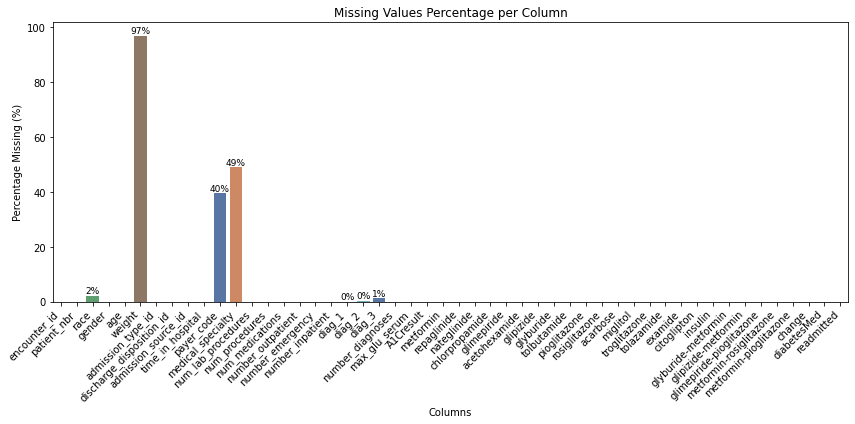

In [10]:
# checkin percentage of missing attribute per column
# Assuming 'df' is your DataFrame
missing_data = dt.isnull().mean() * 100  # Calculate the percentage of missing values per column

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data.values, palette='deep')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate the bars with percentage values (if greater than 0)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',fontsize=9)
plt.show()

# ---> We need to look how to impute missing data from race, , payer code, medical specialty, Diag[1,2,3]

## ---> Run a model to predict missing variables

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto").fit(dt)

In [14]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Perform hierarchical clustering
dendrogram = sch.dendrogram(sch.linkage(dt, method='ward'))

# Customize the plot (optional)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

# Assuming 'dt' is your DataFrame
a = dt.select_dtypes(include=['object']).columns.tolist()
a.remove("medical_specialty")
data_model = dt.dropna(subset=['medical_specialty'])

data_model = pd.get_dummies(data_model, columns=a, drop_first=True)
X=data_model.drop("medical_specialty",axis=1)
y=data_model["medical_specialty"]

# Create a base classifier (e.g., Support Vector Machine)
base_classifier = SVC(probability=True, random_state=42)

# Create the SelfTrainingClassifier
self_training_classifier = SelfTrainingClassifier(
    base_classifier, criterion='k_best', k_best=50
)

# Fit the SelfTrainingClassifier on the labeled data
self_training_classifier.fit(X, y)

self_training.predict(dt[dt['medical_specialty'].isnull()])


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/sklearn/semi_supervised/_self_training.py:210: UserWarning: y contains no unlabeled samples
  warnings.warn("y contains no unlabeled samples", UserWarning)
/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/sklearn/semi_supervised/_self_training.py:219: UserWarning: k_best is larger than the amount of unlabeled samples. All unlabeled samples will be labeled in the first iteration
  UserWarning,


In [ ]:


# Predict on the unlabeled data (self-training step)
y_unlabeled_pred = self_training_classifier.predict(X_unlabeled)

# Combine labeled and newly labeled data
X_combined = np.vstack([X_labeled, X_unlabeled])
y_combined = np.hstack([y_labeled, y_unlabeled_pred])

# Evaluate the SelfTrainingClassifier on the combined dataset
accuracy = self_training_classifier.score(X_combined, y_combined)

print(f'Accuracy after self-training: {accuracy:.2f}')




In [28]:
data_model.head()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,readmitted_>30,readmitted_NO
0,2278392,8222157,6,25,1,1,Pediatrics-Endocrinology,41,0,1,...,0,1,0,0,0,0,1,0,0,1
9,15738,63555939,3,3,4,12,InternalMedicine,33,3,18,...,0,1,0,0,0,0,0,1,0,1
12,40926,85504905,1,3,7,7,Family/GeneralPractice,60,0,15,...,0,1,0,0,0,0,0,1,0,0
13,42570,77586282,1,6,7,10,Family/GeneralPractice,55,1,31,...,0,1,0,0,0,0,1,1,0,1
17,84222,108662661,1,1,7,3,Cardiology,29,0,11,...,0,1,0,0,0,0,1,1,0,1


In [24]:
data_model["race"].unique()

array([2, 4, 0, 5, 1, 3])

In [227]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Sample DataFrame 'dt' with both categorical and numerical columns
# Assuming 'categorical_column' is a categorical column, and 'numerical_column' is a numerical column

a=list(dt.select_dtypes(include=['object']).columns)
a.remove("medical_specialty")
print(a)
# Encode categorical columns (Label Encoding)
label_encoder = LabelEncoder()
dt['categorical_column'] = label_encoder.fit_transform(dt[[a]])

# # Scale numerical columns (Standardization)
# scaler = StandardScaler()
# dt['numerical_column'] = scaler.fit_transform(dt[['numerical_column']])

# Apply K-Means
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(dt)

# Access cluster assignments and cluster centers
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_


KeyError: "None of [Index([('race', 'gender', 'age', 'weight', 'payer_code', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted')], dtype='object')] are in the [columns]"

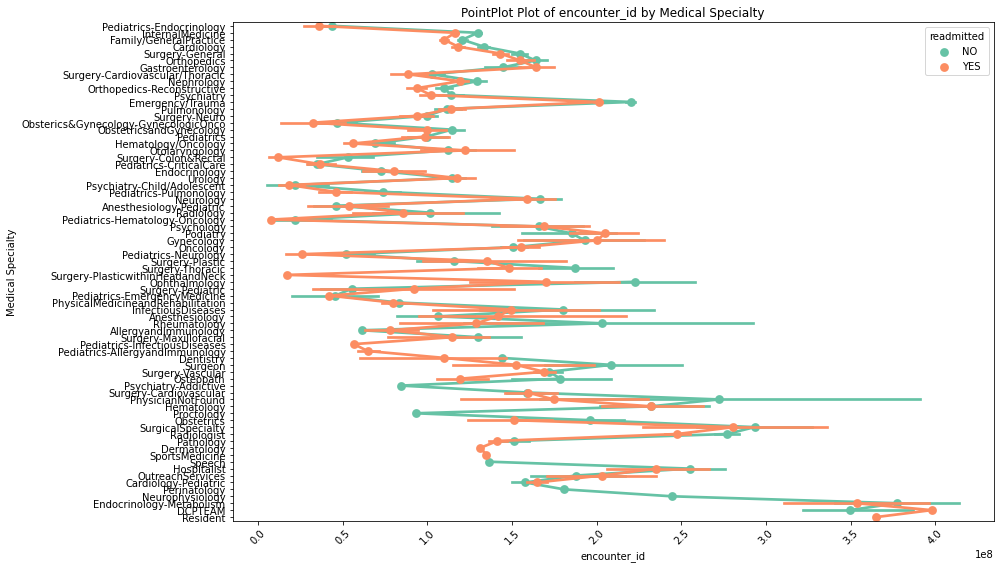

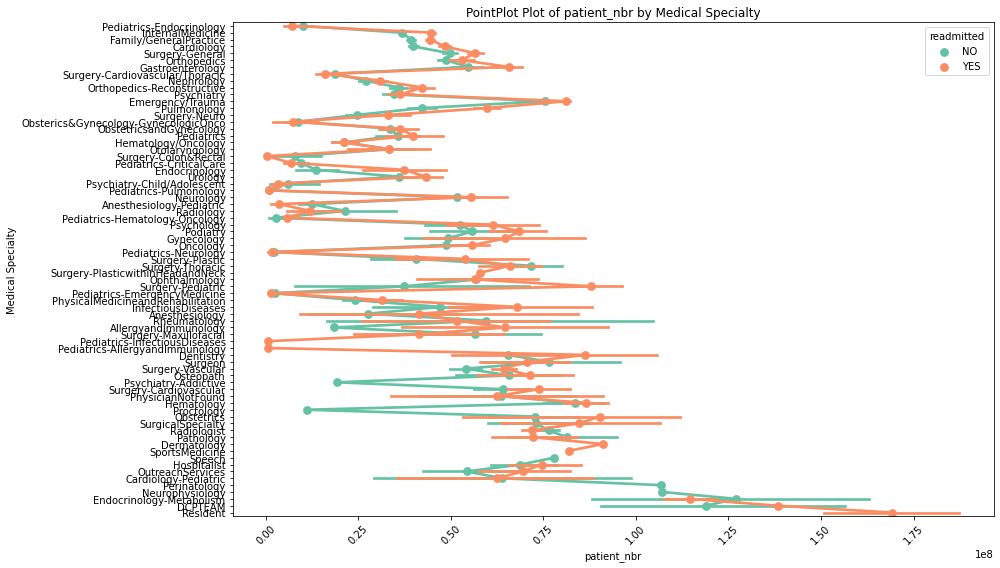

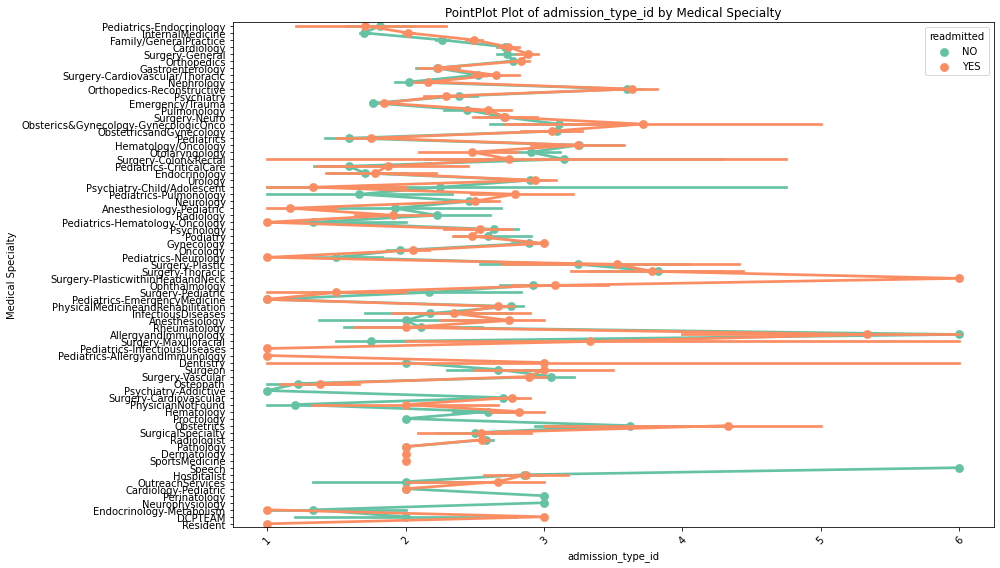

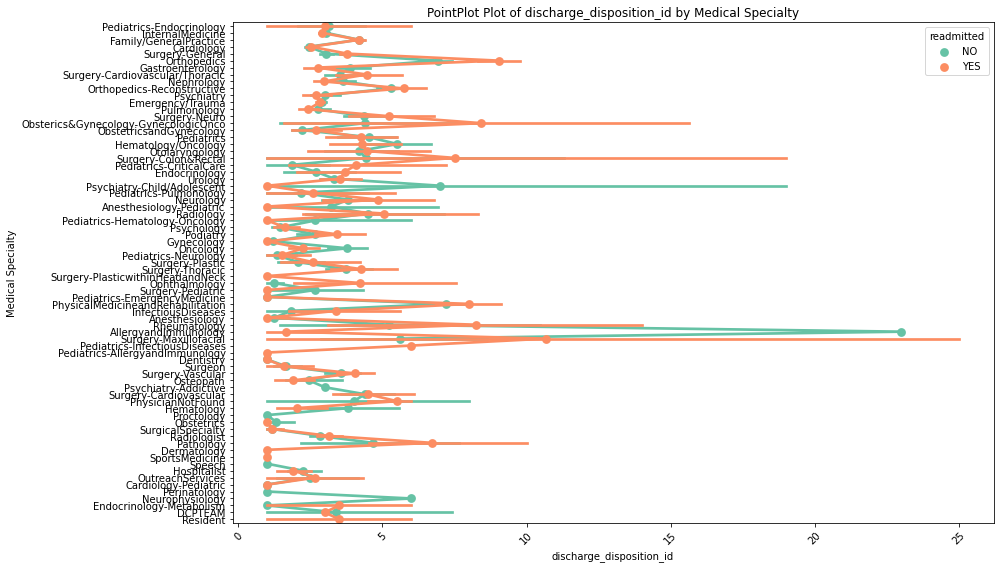

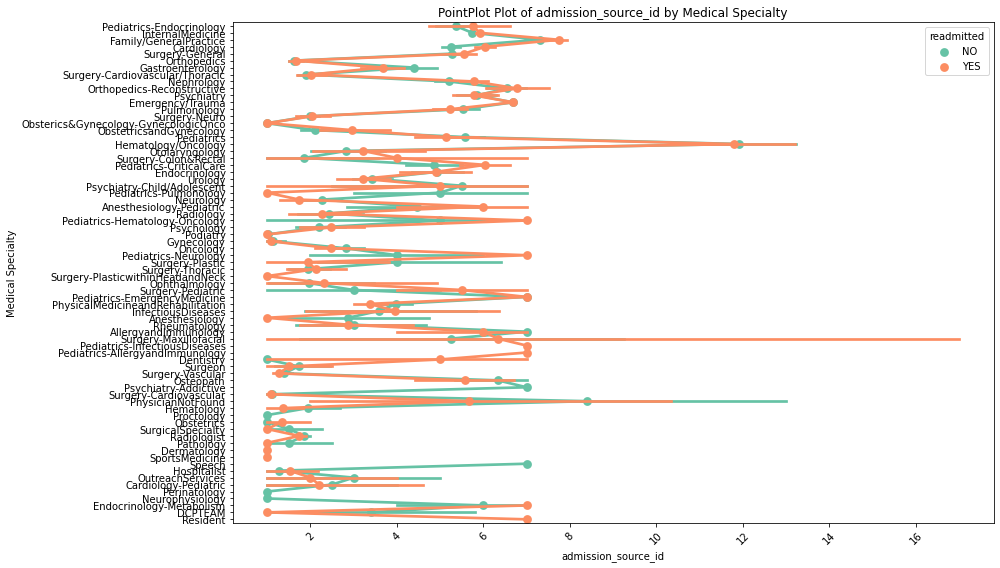

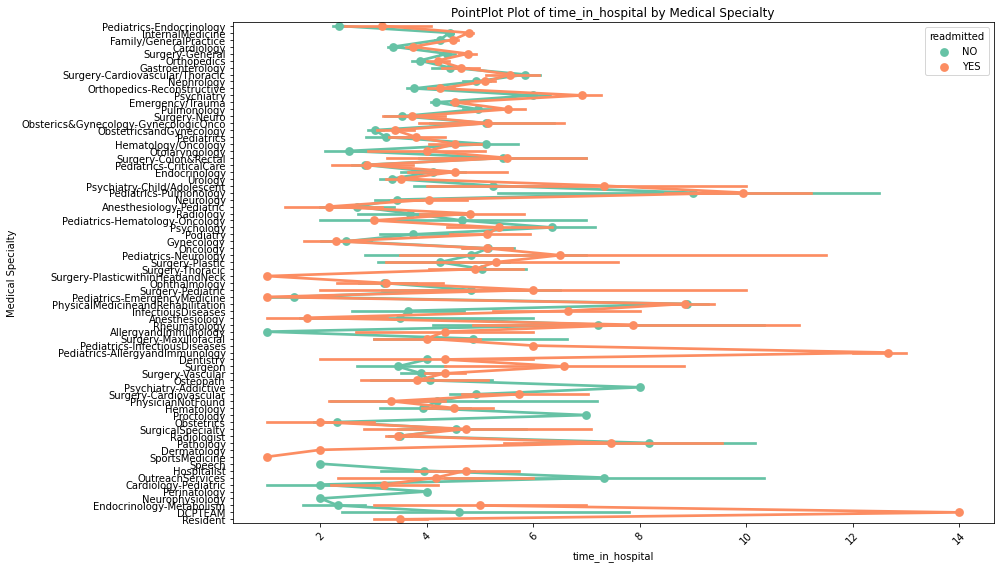

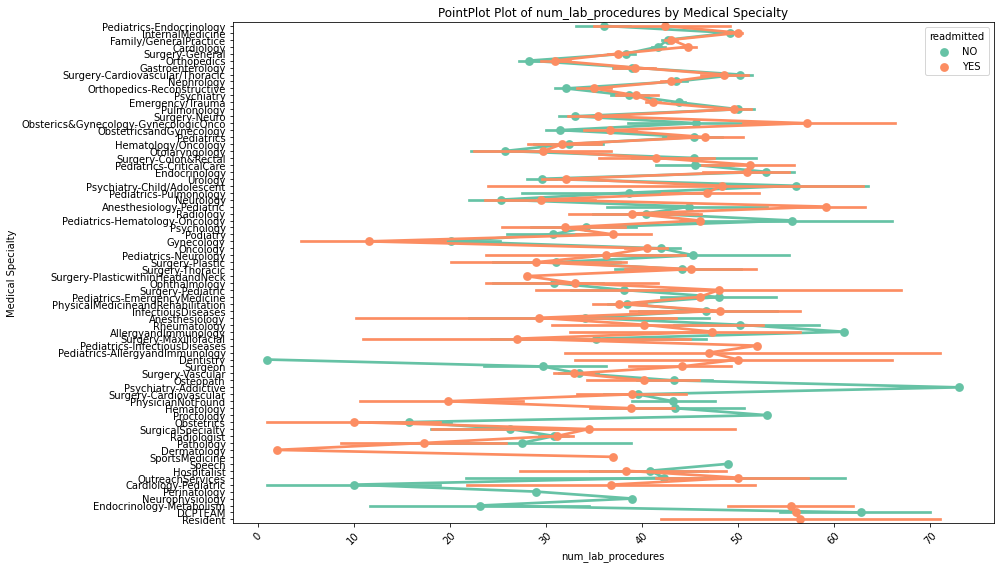

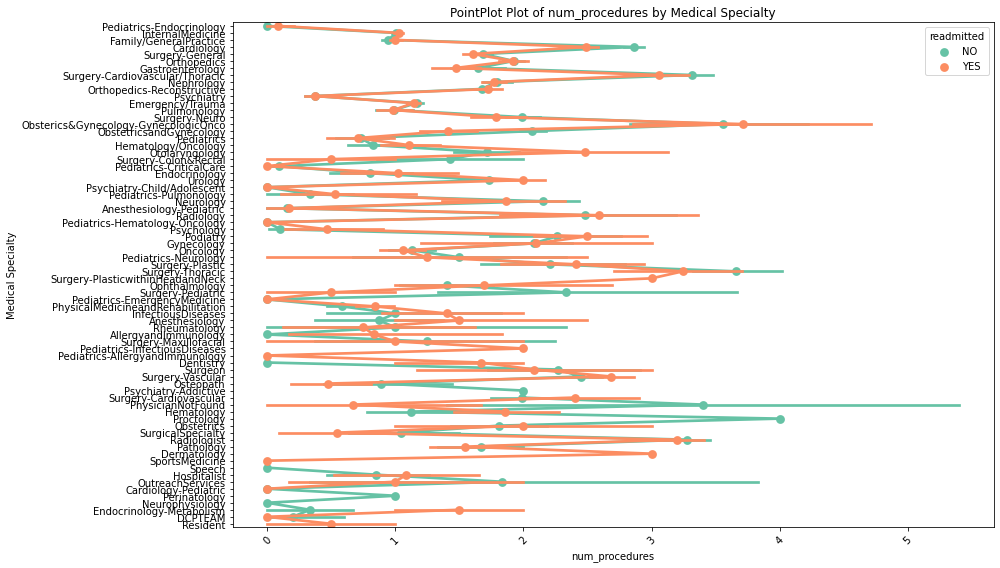

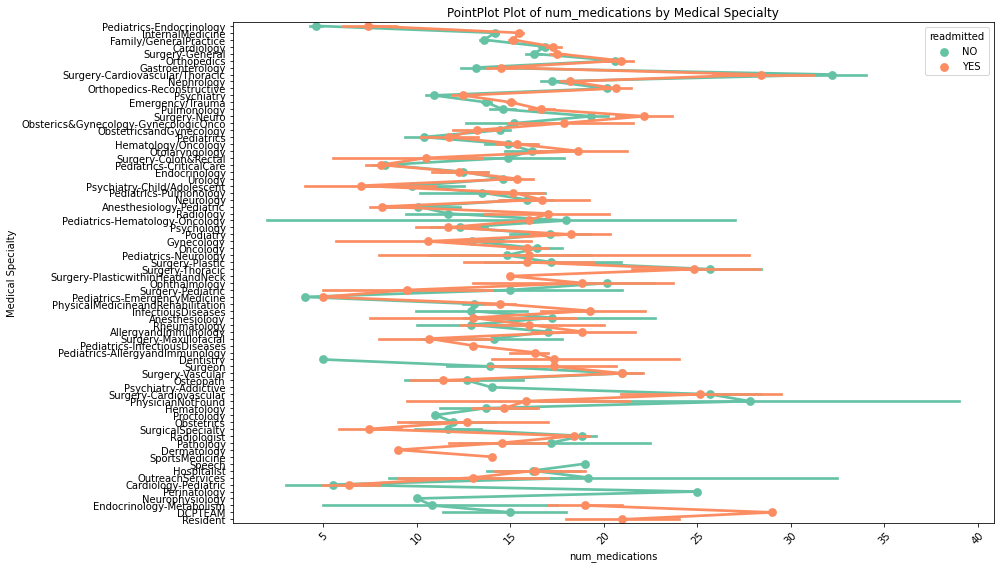

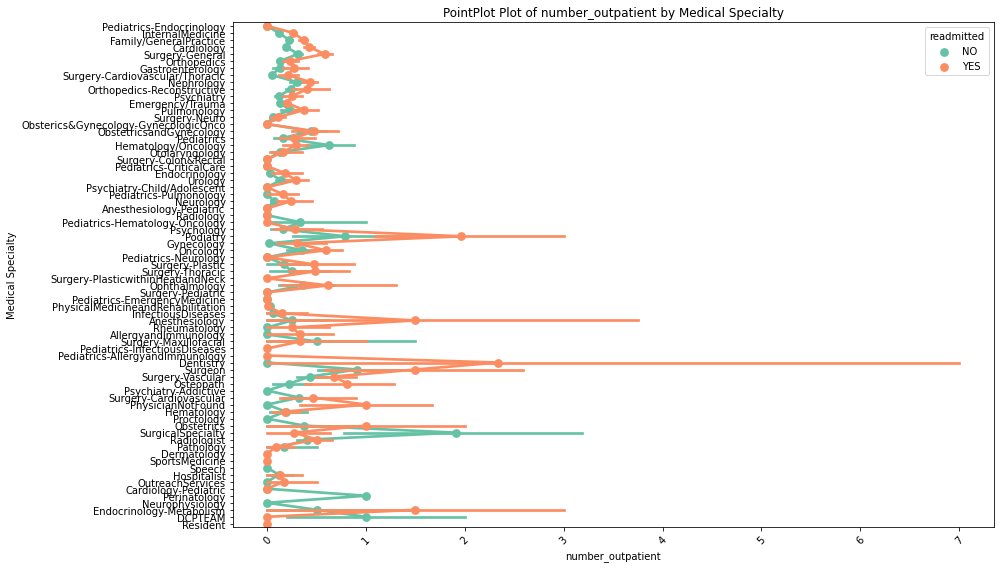

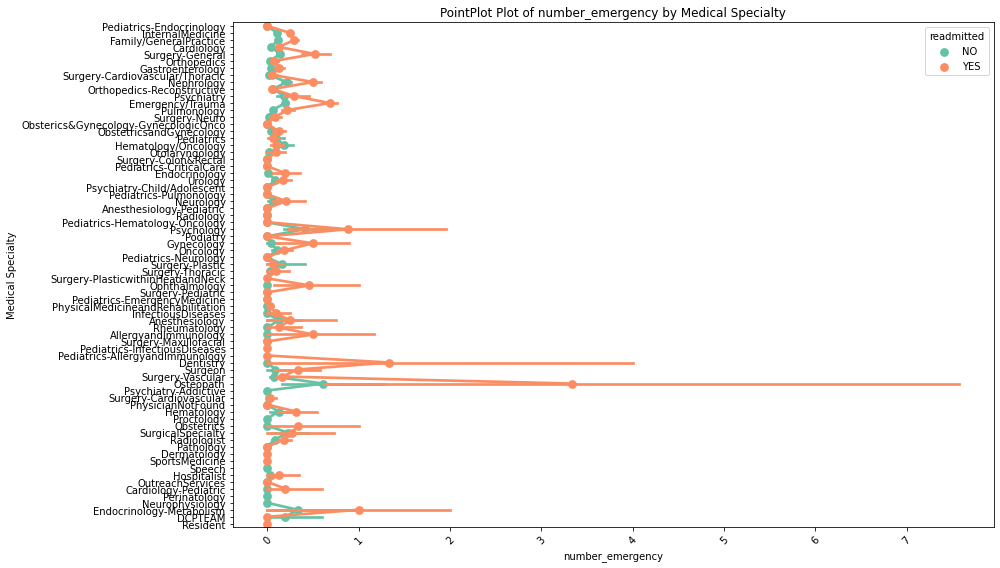

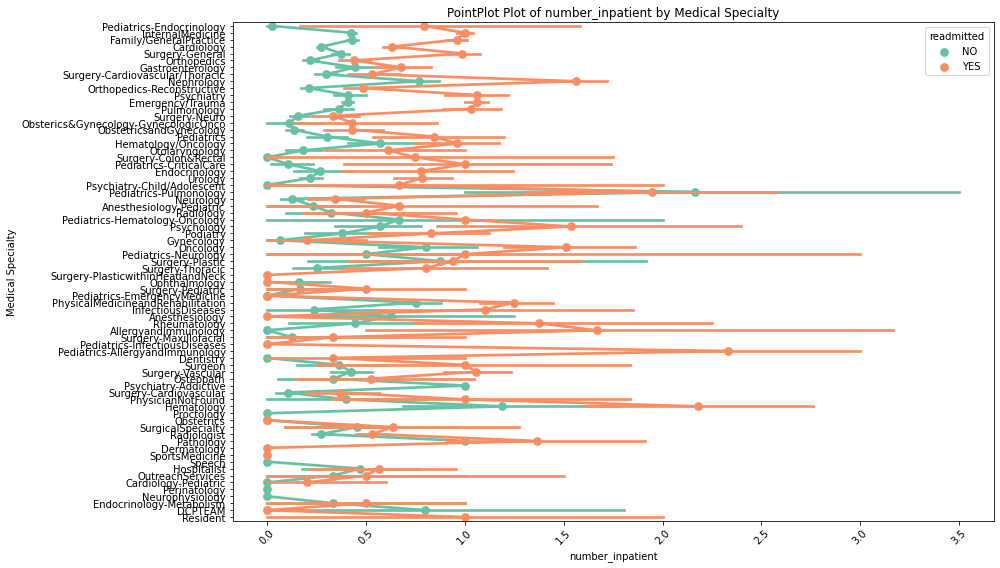

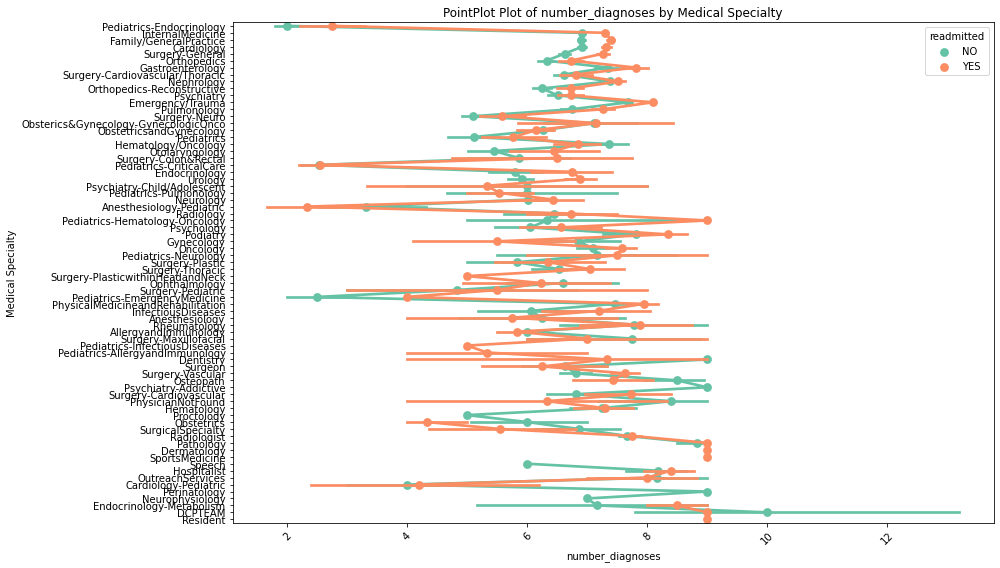

In [136]:
# Create a violin plot for each numeric column
for i in dup_data.select_dtypes(include=['int64']).columns:
    plt.figure(figsize=(14, 8))
    sns.pointplot(y='medical_specialty', x=i, hue="readmitted",data=dup_data, palette="Set2")
    plt.title(f'PointPlot Plot of {i} by Medical Specialty')
    plt.ylabel('Medical Specialty')
    plt.xlabel(i)
    plt.xticks(rotation=45)  
    plt.tight_layout()  # Improve spacing between plots

    plt.show()

In [12]:
new=dt[dt['medical_specialty'].isnull()]

a=list(dt.select_dtypes(include=['object']).columns)
a.remove("medical_specialty")


new = pd.get_dummies(new, columns=a)

# x = new.drop("medical_specialty",axis=1)
# y = new["medical_specialty"]


In [17]:
data_encoded.columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient',
       ...
       'metformin-rosiglitazone_Steady', 'metformin-pioglitazone_No',
       'metformin-pioglitazone_Steady', 'change_Ch', 'change_No',
       'diabetesMed_No', 'diabetesMed_Yes', 'readmitted_<30', 'readmitted_>30',
       'readmitted_NO'],
      dtype='object', length=2410)

In [20]:
# # Separate features (X) and target variable (y)
# X = dt.drop(columns=['medical_specialty'])
# y = dt['medical_specialty']

categorical_columns=list(dt.select_dtypes(include=['object']).columns)
categorical_columns.remove("medical_specialty")

# Define categorical and continuous column lists
continuous_columns = dt.select_dtypes(include=['int64']).columns

# One-hot encode categorical columns
data_encoded = pd.get_dummies(dt, columns=categorical_columns)

# Combine one-hot encoded categorical columns with numeric columns
data_encoded = pd.concat([dt[continuous_columns], data_encoded], axis=1)
X = data_encoded
y = dt['medical_specialty']

from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

model=SVC( gamma='auto')
self_training_model=SelfTrainingClassifier(model)
self_training_model.fit(X,y)

# categorical_encoder = OneHotEncoder(handle_unknown='ignore')
# X_categorical_encoded = categorical_encoder.fit_transform(X[categorical_columns])

# # Preprocessing for numerical data
# numeric_imputer = SimpleImputer(strategy='mean')
# X[continuous_columns] = numeric_imputer.fit_transform(X[continuous_columns])

# scaler = StandardScaler()
# X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

# # Combine categorical and continuous features
# X_encoded = pd.concat([pd.DataFrame(X_categorical_encoded.toarray()), X[continuous_columns]], axis=1)

# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# # Define the model
# model = RandomForestClassifier()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy on Test Data: {accuracy}')


ValueError: could not convert string to float: 'Pediatrics-Endocrinology'

In [219]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error



# Split the data into "missing" and "complete" datasets
# x = dt[dt[target_variable].isnull()]

new=dt[dt['medical_specialty'].isnull()]
a=list(new.select_dtypes(include=['object']).columns)
new = pd.get_dummies(new, columns=a)
a.remove("medical_specialty")

x = new.drop("medical_specialty",axis=1)
y = new["medical_specialty"]


X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)


model = RandomForestRegressor()
model.fit(X_train, y_train)
# missing_['predicted_values'] = model.predict(missing_[features])

# # Evaluate the model's predictions (for regression, you can use metrics like RMSE)
# mse = mean_squared_error(y_test, model.predict(X_test))
# print(f'Mean Squared Error on Test Data: {mse}')

# Optionally, impute the missing values in your original dataset
#data.loc[data[target_variable].isnull(), target_variable] = missing_['predicted_values']

# Now your dataset may have the missing variable imputed


KeyError: "['medical_specialty'] not found in axis"

In [180]:
y_train=dt[dt["medical_specialty"]]-dt[dt["medical_specialty"].isnull()]
y_test=dt[dt["medical_specialty"].isnull()]["medical_specialty"]



x=dt.drop("medical_specialty", axis=1)


In [185]:
dt[dt["medical_specialty"]]-dt[dt["medical_specialty"].isnull()]

KeyError: "None of [Index(['Pediatrics-Endocrinology',                        nan,\n                              nan,                        nan,\n                              nan,                        nan,\n                              nan,                        nan,\n                              nan,         'InternalMedicine',\n       ...\n                              nan,                        nan,\n                              nan,                        nan,\n                              nan,                        nan,\n                              nan,                        nan,\n                'Surgery-General',                        nan],\n      dtype='object', length=101766)] are in the [columns]"

In [182]:
dt["medical_specialty"]-dt[dt["medical_specialty"].isnull()]

KeyboardInterrupt: 

In [179]:
x.shape

(101766, 49)

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

y=
target_variable = 'missing_variable'

# Split the data into "missing" and "complete" datasets
missing_ = dt[dt[target_variable].isnull()]
complete_ = dt.dropna(subset=[target_variable])

# Identify featuredt (predictors)
features = ['medical_specialty', 'payer_code']


X_train, X_test, y_train, y_test = train_test_split(complete_[features],complete_[target_variable],test_size=0.2,random_state=42)


model = RandomForestRegressor()
model.fit(X_train, y_train)
missing_['predicted_values'] = model.predict(missing_dat[features])

# Evaluate the model's predictions (for regression, you can use metrics like RMSE)
mse = mean_squared_error(y_test, model.predict(X_test))
print(f'Mean Squared Error on Test Data: {mse}')

# Optionally, impute the missing values in your original dataset
#data.loc[data[target_variable].isnull(), target_variable] = missing_['predicted_values']

# Now your dataset may have the missing variable imputed


KeyError: None

<Figure size 1080x1152 with 0 Axes>

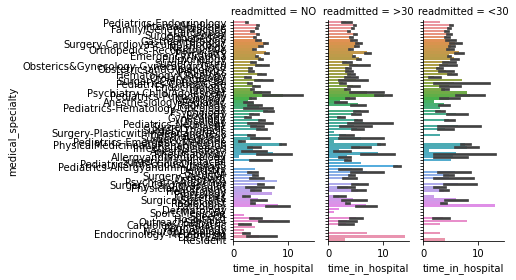

In [114]:
plt.figure(figsize=(15, 16))
sns.catplot(
    data=dt, y="medical_specialty", x="time_in_hospital", col="readmitted",
    kind="bar", height=4, aspect=.6,
)
plt.show()

In [ ]:
for 

In [ ]:
# Imputing Medical Speciaty
+ 73 types 


In [102]:

dt[dt["race"].isna()].describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,2.273000e+03,2.273000e+03,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000,2273.000000
mean,1.728853e+08,4.409962e+07,1.882094,2.611967,5.031676,4.289485,44.104707,1.302684,15.813462,0.194457,0.044435,0.305763,6.695557
std,1.123099e+08,3.871054e+07,1.173805,3.618331,3.583616,2.900759,18.685559,1.794916,8.460162,0.716398,0.252202,0.735330,2.115016
min,1.485300e+05,3.643200e+04,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,9.416557e+07,1.307793e+07,1.000000,1.000000,1.000000,2.000000,33.000000,0.000000,10.000000,0.000000,0.000000,0.000000,5.000000
50%,1.107493e+08,3.823173e+07,2.000000,1.000000,6.000000,4.000000,45.000000,0.000000,14.000000,0.000000,0.000000,0.000000,7.000000
75%,2.545663e+08,6.480508e+07,2.000000,3.000000,7.000000,6.000000,57.000000,2.000000,19.000000,0.000000,0.000000,0.000000,9.000000
max,4.437285e+08,1.880406e+08,8.000000,28.000000,20.000000,14.000000,98.000000,6.000000,64.000000,11.000000,3.000000,8.000000,16.000000


In [105]:
dt.shape

(101766, 50)

In [107]:
sns.pairplot(dt.iloc[:,:25], hue="race")

In [ ]:
sns.pairplot(dt.iloc[:,25:], hue="race")

In [ ]:
#K^2

In [ ]:
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

ax = scatter_matrix(dt,figsize=(15, 10))

In [ ]:
# Since we are missing 97% of Weight, it will be dropped 
dt.drop([["weight","medical_specialty","encounter_id","patient_nbr"]],axis=1)

# Looking at the categorical variable

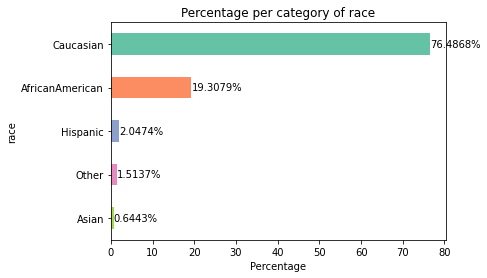

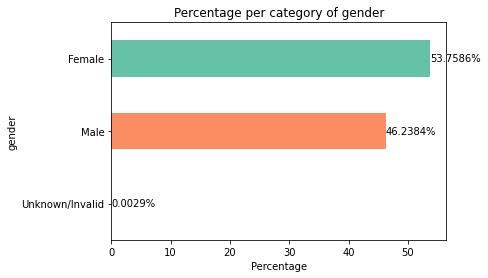

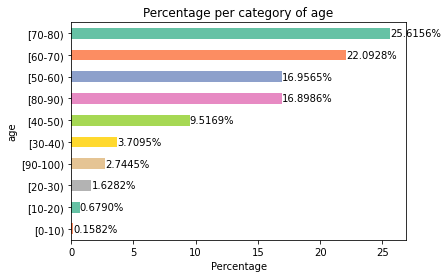

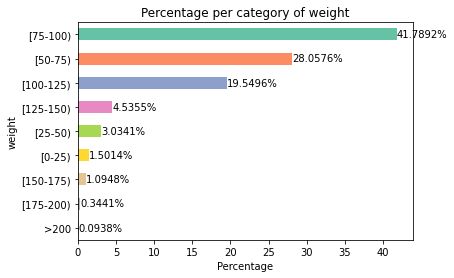

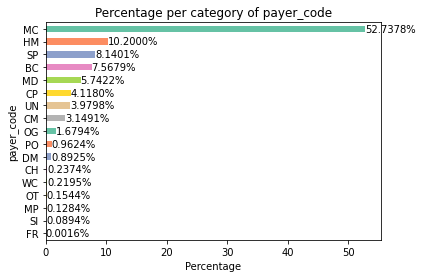

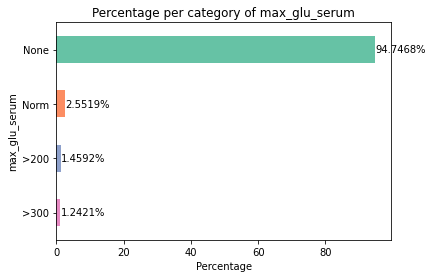

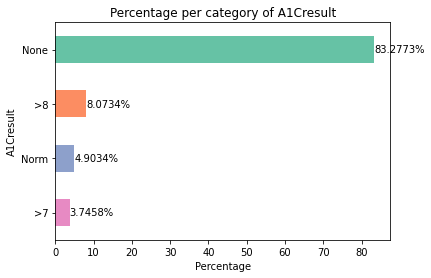

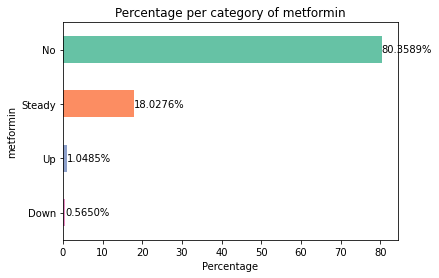

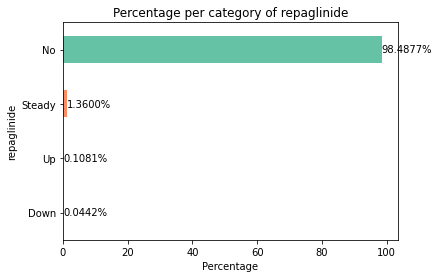

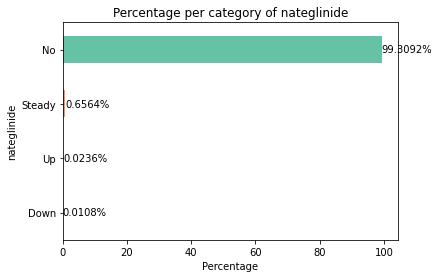

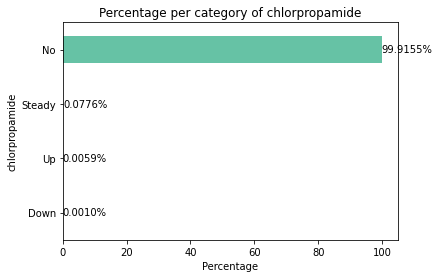

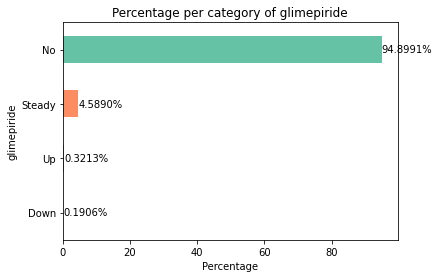

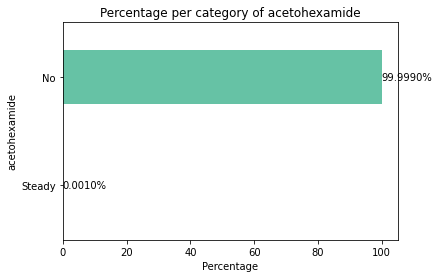

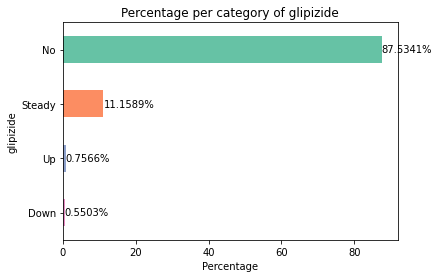

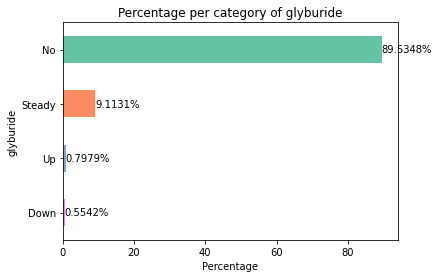

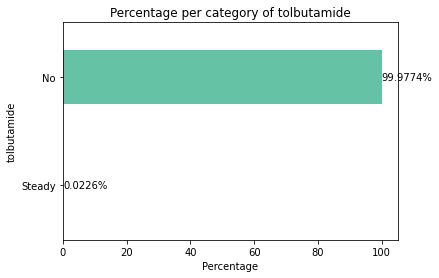

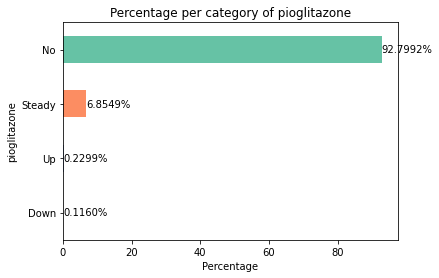

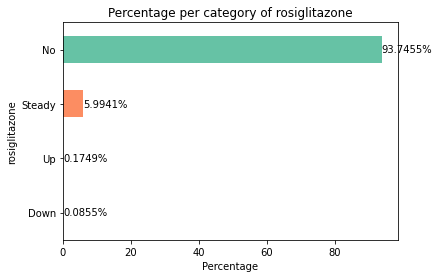

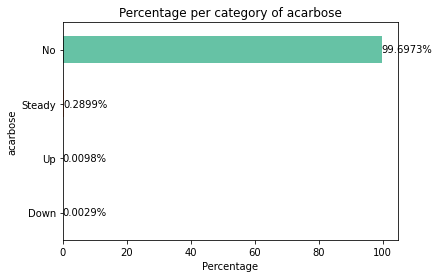

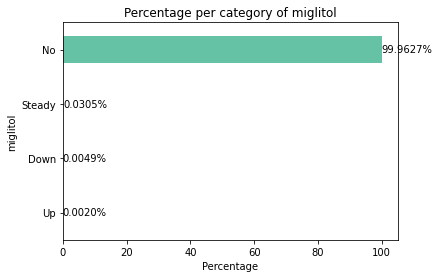

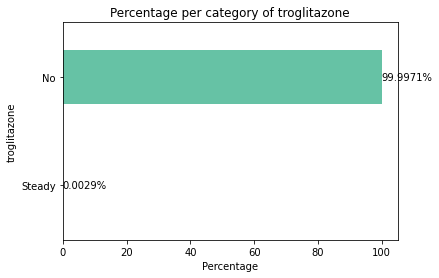

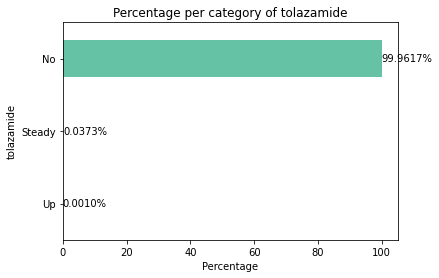

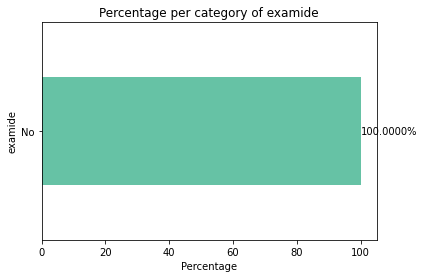

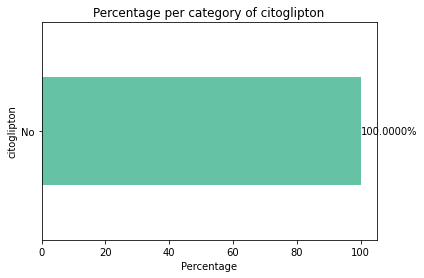

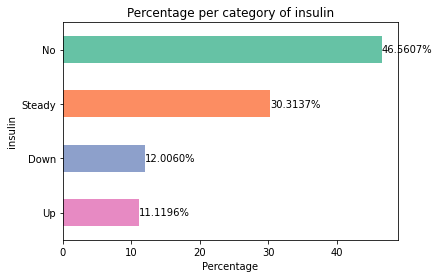

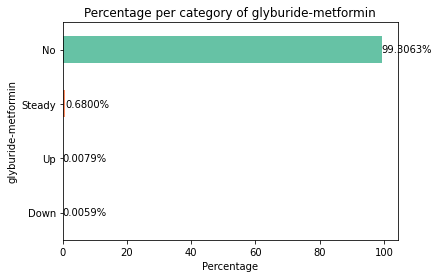

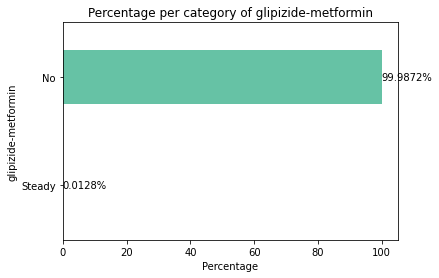

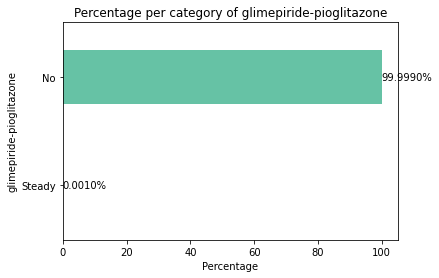

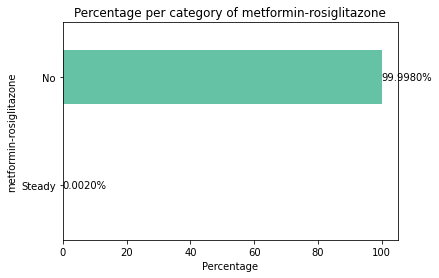

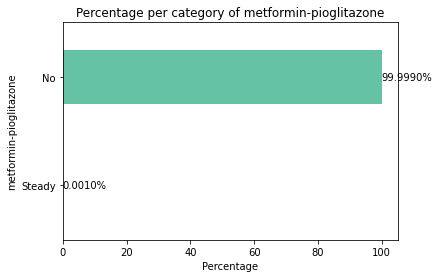

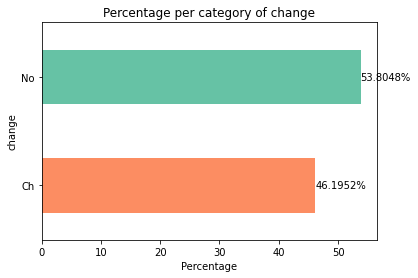

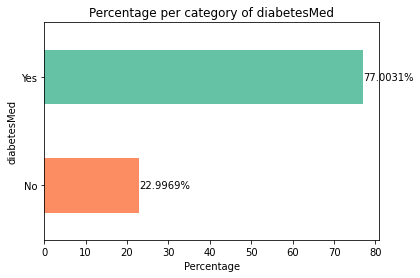

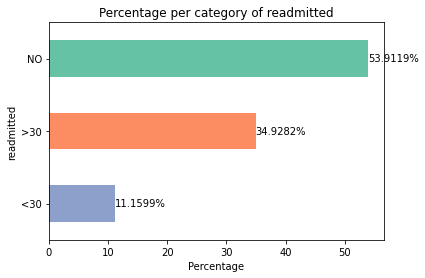

In [62]:
#Assuming 'data' is your DataFrame
cat_df = dt.select_dtypes(include=['object']).drop(["medical_specialty", "diag_1", "diag_2", "diag_3""diag_1", "diag_2", "diag_3"], axis=1)

# Get the number of unique categories for each column
num_categories = cat_df.nunique()

# Define a color palette with as many colors as there are unique categories
color_palette = sns.color_palette("Set2", n_colors=num_categories.max())

for i in cat_df.columns:
    value_counts = dt[i].value_counts(normalize=True)
    colors = color_palette[:len(value_counts)]
    
    ax = value_counts.mul(100).plot(kind="barh", color=colors)
    
    plt.xlabel("Percentage")
    plt.ylabel(i)
    plt.title(f"Percentage per category of {i}")
    plt.gca().invert_yaxis()
    
    for index, value in enumerate(value_counts.mul(100)):
        ax.text(value, index, f'{value:.4f}%', ha='left', va='center', color='black')

    plt.show()


+ 76% is Caucasian
+ Age bucket is larger and ther is a correlation the older get hospitilized more 
+ Drop citoglipton and examide since the only value is "No"

In [59]:
# Droping examide and citoglipton which only had 1 as the value
dt=dt.drop(dt[['examide','citoglipton']], axis=1)

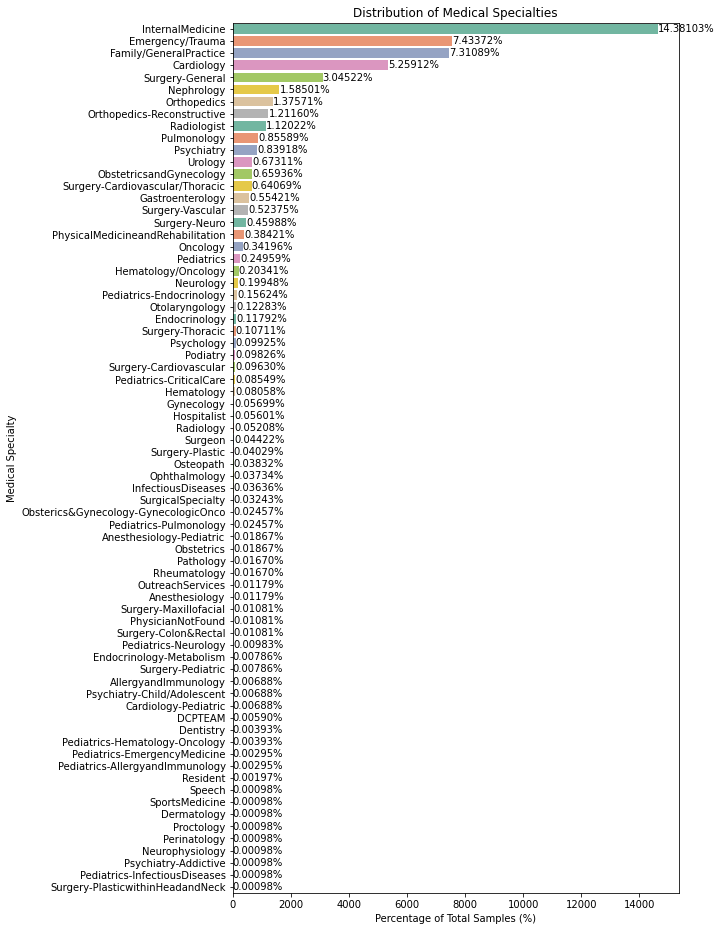

In [108]:
# Create a countplot with percentages and sorted categories
plt.figure(figsize=(8, 16))
sns.countplot(
    y=dt['medical_specialty'],
    orient='h',
    palette='Set2',
    order=dt['medical_specialty'].value_counts().index,  # Sort by count
)
plt.xlabel('Percentage of Total Samples (%)')
plt.ylabel('Medical Specialty')
plt.title('Distribution of Medical Specialties')

# Annotate the bars with percentage values
for p in plt.gca().patches:
    width = p.get_width()
    percentage = (width / len(dt)) * 100
    plt.gca().annotate(f'{percentage:.5f}%', (width + 1, p.get_y() + p.get_height() / 2), ha='left', va='center')

plt.show()


In [ ]:
# Fix "diag_1", "diag_2", "diag_3"

In [61]:
data.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

1: max diag ==1 rest 0 -->1,0,0
2: all ? to 0

In [55]:
data.iloc[:,18:21]

,diag_1,diag_2,diag_3
0,250.83,?,?
1,276,250.01,255
2,648,250,V27
3,8,250.43,403
4,197,157,250
...,...,...,...
101761,250.13,291,458
101762,560,276,787
101763,38,590,296
101764,996,285,998


# Looking numerical features

In [45]:
data["discharge_disposition_id"]==

0         25
1          1
2          1
3          1
4          1
          ..
101761     3
101762     4
101763     1
101764     3
101765     1
Name: discharge_disposition_id, Length: 101766, dtype: int64

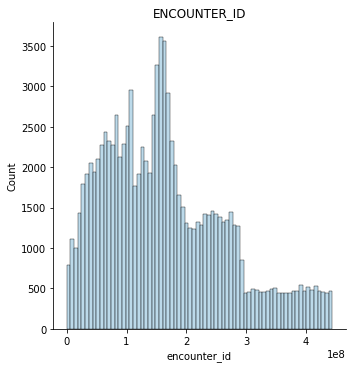

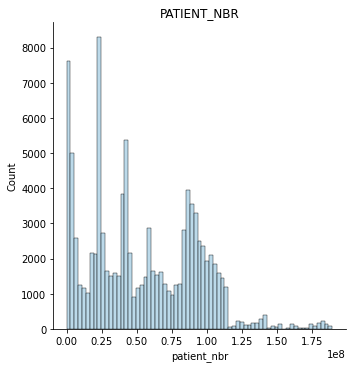

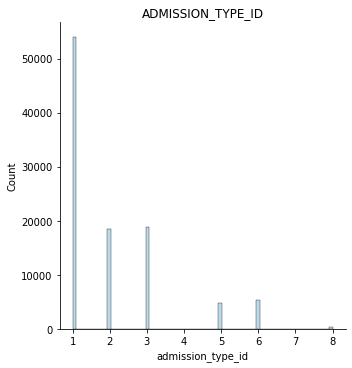

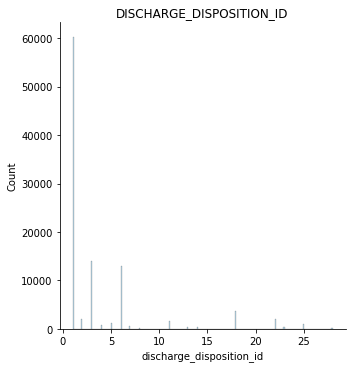

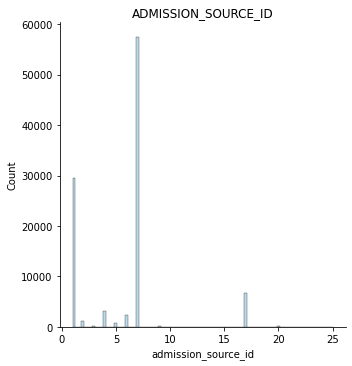

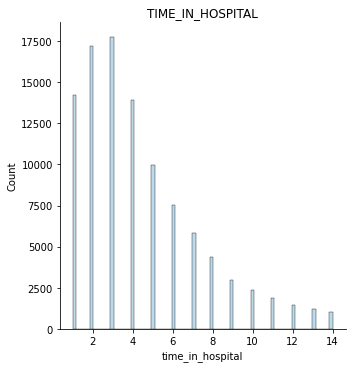

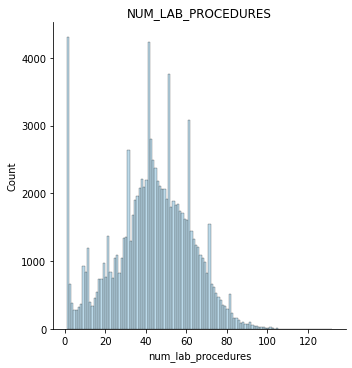

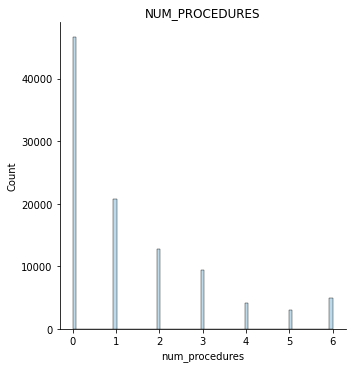

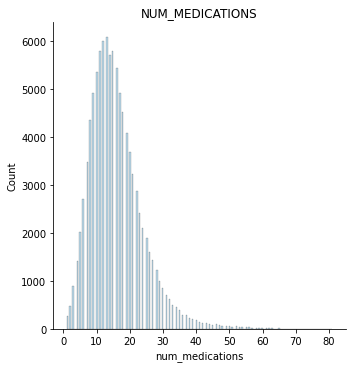

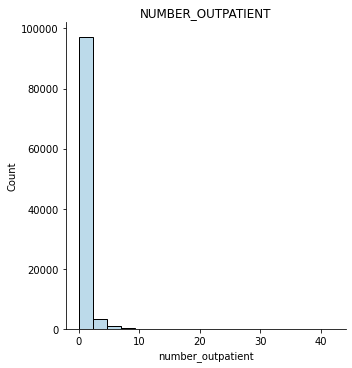

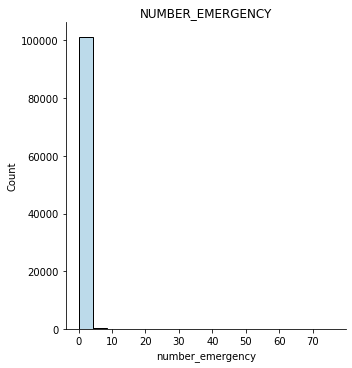

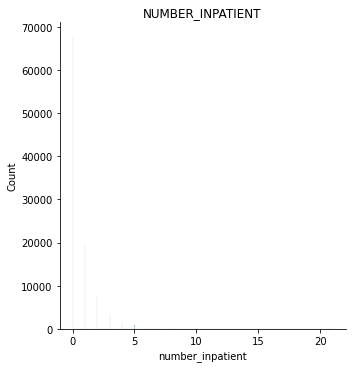

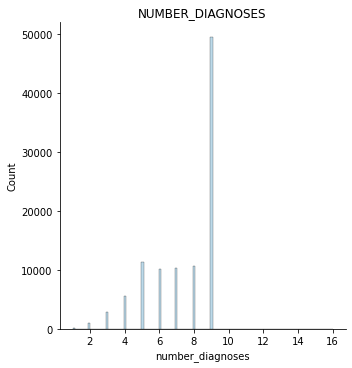

In [28]:
# Creating df of only Continuous variables
num_df = dt.f_get_numeric_data()
sns.set_palette("Paired")
for i in list(num_df):
    sns.displot(dt[i], kde=False)
    plt.title(i.upper())
    plt.show()

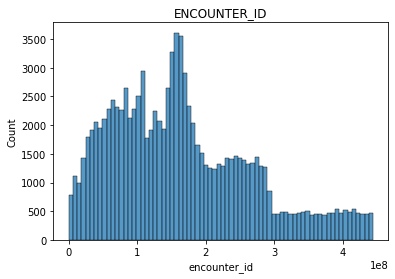

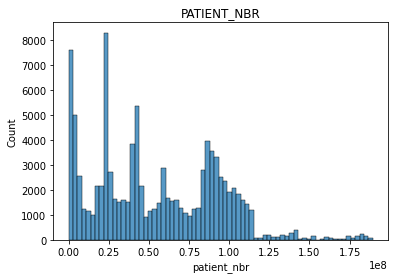

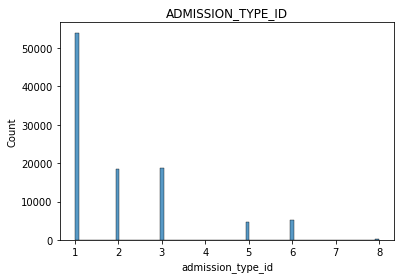

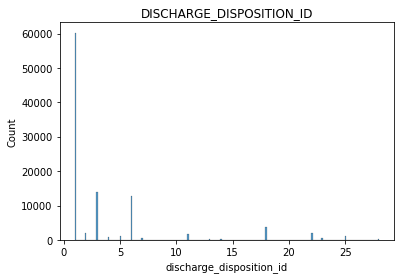

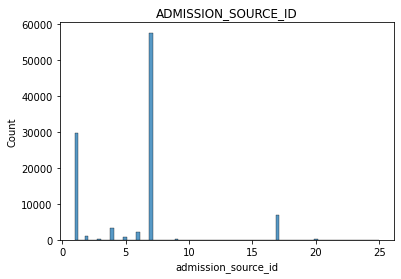

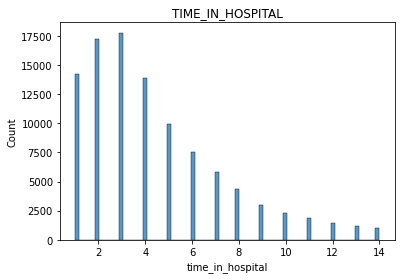

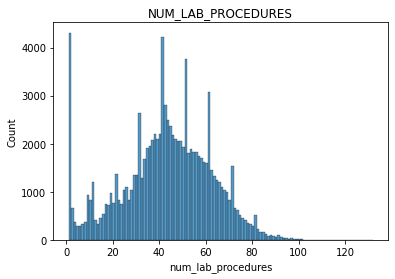

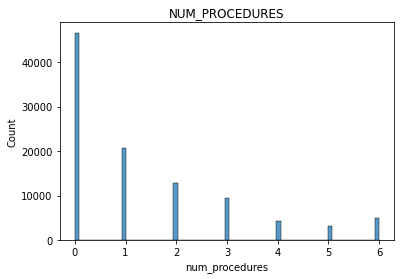

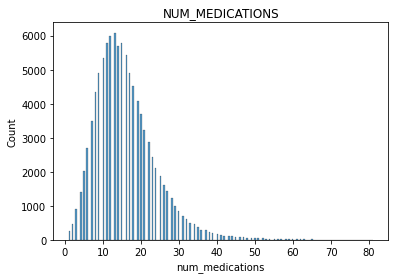

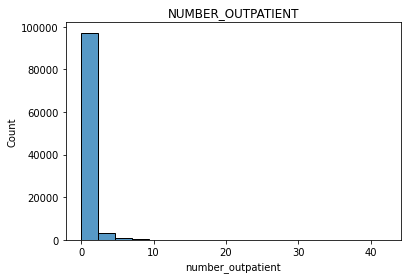

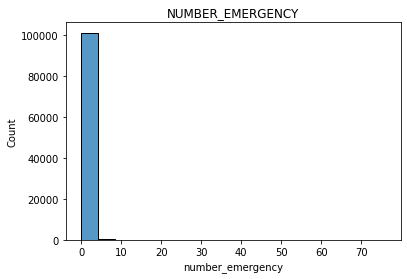

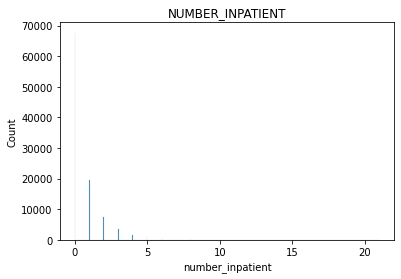

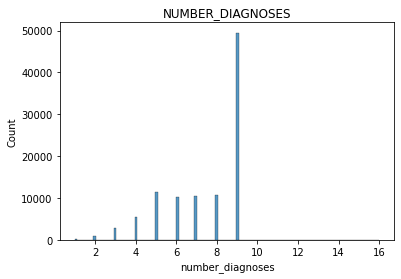

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in data.select_dtypes(include=['int64']).columns:
    sns.histplot(data[i],kde=False)
    plt.title(i.upper())
    plt.show()
#admission_type_id -> Difference between 5 Not Available, 8 Not Mapped, 6 NULL
#discharge_disposition_id -> 18 NULL, 25 Not Mapped, 26 Unknown/Invalid
#admission_source_id-->9 NOT AVAILable, 15 NOT AVAILable ,17 NULL
#<---- treat as categorical

#time in hospital
#num of procedures
#interesting num of medication is normaly distributed
#number_outpatient
#number_emergency
#number_inpatient
#num diagnoses

In [21]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [135]:
# Combining our targe to Yes and No instead of [No, >30, <30]
dup_data = dt.copy()

# Update "readmitted" column
dup_data.loc[dup_data["readmitted"] == ">30", "readmitted"] = "YES"
dup_data.loc[dup_data["readmitted"] == "<30", "readmitted"] = "YES"

# Check unique values in "readmitted" column
print(dup_data["readmitted"].unique())

['NO' 'YES']


# ---> talk about using gender,race and age in data at the end